## An Exploration of 2023 NYC Arrests Data

In [40]:
# imports 

import pandas as pd 
import numpy as np
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(style="dark")

In [44]:
# load the data

arrests_2023 = pd.read_csv('../data/arrests_2023.csv')
arrests_2023.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,279755734,12/31/2023,639.0,AGGRAVATED HARASSMENT 2,361.0,OFF. AGNST PUB ORD SENSBLTY &,PL 240301B,M,M,14,0,25-44,M,WHITE,986050,214231,40.754692,-73.993500,POINT (-73.9935 40.754692)
1,279763501,12/31/2023,652.0,RIOT 2/INCITING,361.0,OFF. AGNST PUB ORD SENSBLTY &,PL 2400800,M,B,40,2,25-44,M,BLACK,1005529,233942,40.808769,-73.923130,POINT (-73.92313 40.808769)
2,279763512,12/31/2023,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,10,0,25-44,F,BLACK,983422,209491,40.741682,-74.002985,POINT (-74.002985 40.741682)
3,279749399,12/31/2023,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,B,43,0,45-64,M,BLACK,1016702,241293,40.828910,-73.882734,POINT (-73.882734 40.82891)
4,279754127,12/31/2023,639.0,AGGRAVATED HARASSMENT 2,361.0,OFF. AGNST PUB ORD SENSBLTY &,PL 240301A,M,B,44,0,25-44,M,BLACK,1008704,243454,40.834867,-73.911629,POINT (-73.911629 40.834867)


In [45]:
# preprocessing the data 

print("Initial shape:", arrests_2023.shape)
# print("Missing values per column:\n", arrests_2023.isnull().sum())
# print("Data types:\n", arrests_2023.dtypes)

# convert arrest_date to proper date time
arrests_2023['ARREST_DATE'] = pd.to_datetime(arrests_2023['ARREST_DATE'], errors='coerce')

# label for consistency
arrests_2023['PERP_RACE'] = (
    arrests_2023['PERP_RACE']
    .str.strip()
    .str.upper()
    .replace({
        'BLACK HISPANIC': 'HISPANIC',
        'WHITE HISPANIC': 'HISPANIC',
        'ASIAN / PACIFIC ISLANDER': 'ASIAN',
        'AMERICAN INDIAN/ALASKAN NATIVE': 'NATIVE AMERICAN',
        'UNKNOWN': None
    })
)
arrests_2023 = arrests_2023.dropna(subset=['PERP_RACE', 'ARREST_PRECINCT'])

# calculate proportions
race_counts = arrests_2023['PERP_RACE'].value_counts(normalize=True) * 100
print(race_counts)

print(f"Preprocessed shape: ", arrests_2023.shape)

Initial shape: (226872, 19)
PERP_RACE
BLACK              48.422785
HISPANIC           35.986635
WHITE               9.800099
ASIAN               5.475975
NATIVE AMERICAN     0.314506
Name: proportion, dtype: float64
Preprocessed shape:  (224161, 19)


**Note:** That’s roughly 84% of all arrests coming from Black and Hispanic individuals — a clear early sign of racial disparity when compared to NYC’s population makeup (~24% Black, ~29% Hispanic, ~31% White).

In [46]:
precinct_race = (
    arrests_2023.groupby(['ARREST_PRECINCT', 'PERP_RACE'])
    .size()
    .reset_index(name='NUM_ARRESTS')
)

precinct_race.head()

,ARREST_PRECINCT,PERP_RACE,NUM_ARRESTS
0,1,ASIAN,116
1,1,BLACK,1046
2,1,HISPANIC,747
3,1,NATIVE AMERICAN,9
4,1,WHITE,413


In [47]:
arrests_2023['ARREST_PRECINCT'].value_counts()

ARREST_PRECINCT
14     7639
44     7148
75     7146
40     7116
103    6141
       ... 
100    1117
123    1003
17     1001
111     866
22       85
Name: count, Length: 77, dtype: int64

              Race   Count  Percent
0            BLACK  108545    48.42
1         HISPANIC   80668    35.99
2            WHITE   21968     9.80
3            ASIAN   12275     5.48
4  NATIVE AMERICAN     705     0.31


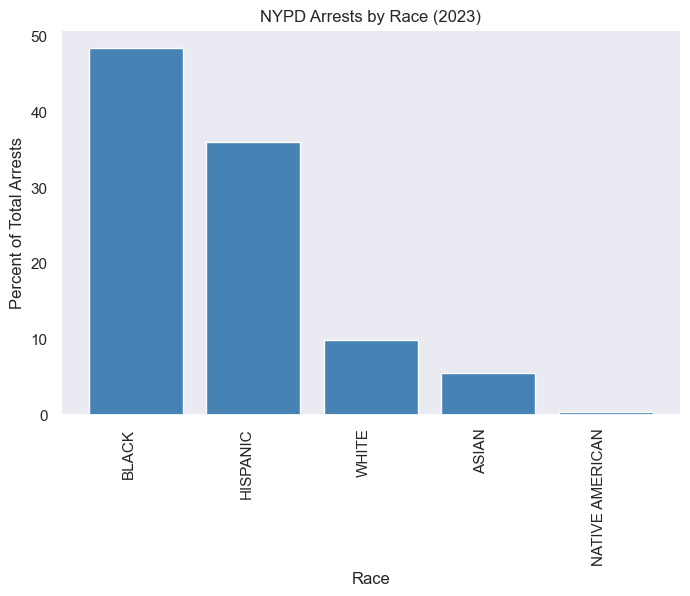

In [48]:
# examining racial composition 

race_counts = arrests_2023["PERP_RACE"].value_counts().reset_index()
race_counts.columns = ["Race", "Count"]
race_counts["Percent"] = (race_counts["Count"] / race_counts["Count"].sum() * 100).round(2)
print(race_counts)

plt.figure(figsize=(8,5))
plt.bar(race_counts["Race"], race_counts["Percent"], color="steelblue")
plt.title("NYPD Arrests by Race (2023)")
plt.xlabel("Race")
plt.ylabel("Percent of Total Arrests")
plt.xticks(rotation=90, ha="right")
plt.show()

In [49]:
# offense types by race 
arrests_2023["OFNS_DESC"] = arrests_2023["OFNS_DESC"].str.strip().str.title()
arrests_2023["LAW_CAT_CD"] = arrests_2023["LAW_CAT_CD"].str.strip().str.title()

offense_race = (
    arrests_2023.groupby(["PERP_RACE", "OFNS_DESC"])
    .size()
    .reset_index(name="Count")
)
offense_race["Rank"] = offense_race.groupby("PERP_RACE")["Count"].rank(
    method="first", ascending=False
)
top_offenses = offense_race[offense_race["Rank"] <= 5].sort_values(
    ["PERP_RACE", "Rank"]
)
print(top_offenses.head(30))


           PERP_RACE                       OFNS_DESC  Count  Rank
4              ASIAN    Assault 3 & Related Offenses   2250   1.0
16             ASIAN                  Felony Assault   1377   2.0
31             ASIAN         Miscellaneous Penal Law    973   3.0
47             ASIAN                   Petit Larceny    940   4.0
11             ASIAN                 Dangerous Drugs    878   5.0
64             BLACK    Assault 3 & Related Offenses  15643   1.0
76             BLACK                  Felony Assault  10316   2.0
107            BLACK                   Petit Larceny  10181   3.0
71             BLACK                 Dangerous Drugs   7367   4.0
92             BLACK         Miscellaneous Penal Law   7298   5.0
123         HISPANIC    Assault 3 & Related Offenses  12498   1.0
167         HISPANIC                   Petit Larceny   8832   2.0
135         HISPANIC                  Felony Assault   7535   3.0
130         HISPANIC                 Dangerous Drugs   5428   4.0
152       

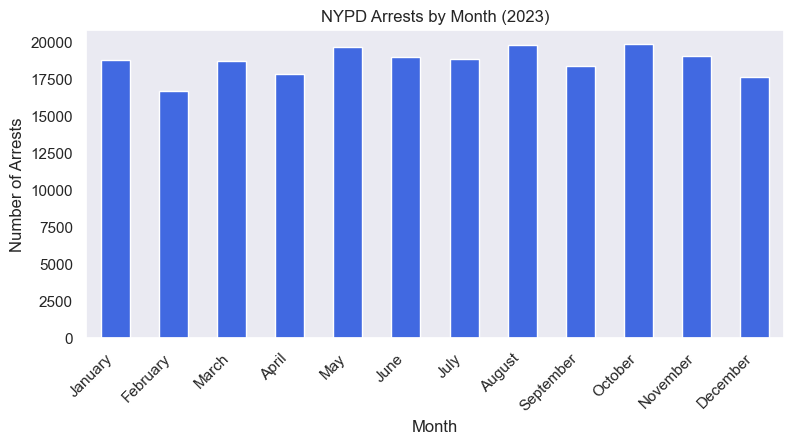

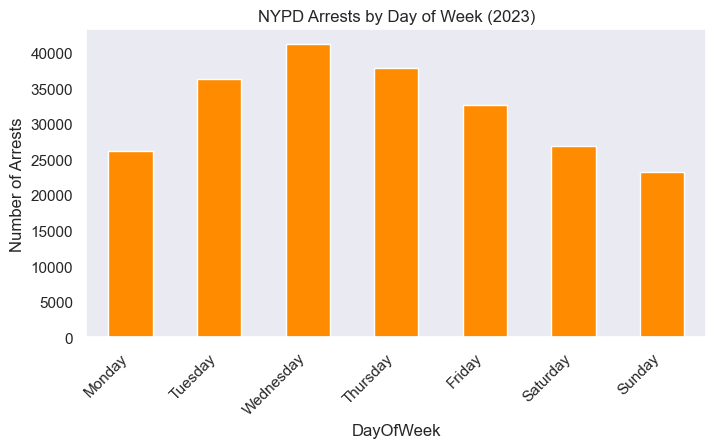

,Month,Arrests,DayOfWeek_Peak
0,January,18755,Wednesday
1,February,16677,Wednesday
2,March,18685,Wednesday
3,April,17855,Wednesday
4,May,19646,Wednesday


In [54]:
# investigate temporal trends 

# --- monthly trends ---
arrests_2023["Month"] = arrests_2023["ARREST_DATE"].dt.month_name()
monthly_counts = (
    arrests_2023["Month"]
    .value_counts()
    .reindex([
        "January","February","March","April","May","June",
        "July","August","September","October","November","December"
    ])
)
plt.figure(figsize=(9,4))
monthly_counts.plot(kind="bar", color="royalblue")
plt.title("NYPD Arrests by Month (2023)")
plt.ylabel("Number of Arrests")
plt.xticks(rotation=45, ha="right")
plt.show()

# --- day-of-week trends ---
arrests_2023["DayOfWeek"] = arrests_2023["ARREST_DATE"].dt.day_name()
dow_counts = (
    arrests_2023["DayOfWeek"]
    .value_counts()
    .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
)
plt.figure(figsize=(8,4))
dow_counts.plot(kind="bar", color="darkorange")
plt.title("NYPD Arrests by Day of Week (2023)")
plt.ylabel("Number of Arrests")
plt.xticks(rotation=45, ha="right")
plt.show()

# --- Optional summary table ---
temporal_summary = pd.DataFrame({
    "Month": monthly_counts.index,
    "Arrests": monthly_counts.values
}).dropna()
temporal_summary["DayOfWeek_Peak"] = dow_counts.idxmax()
temporal_summary.head()

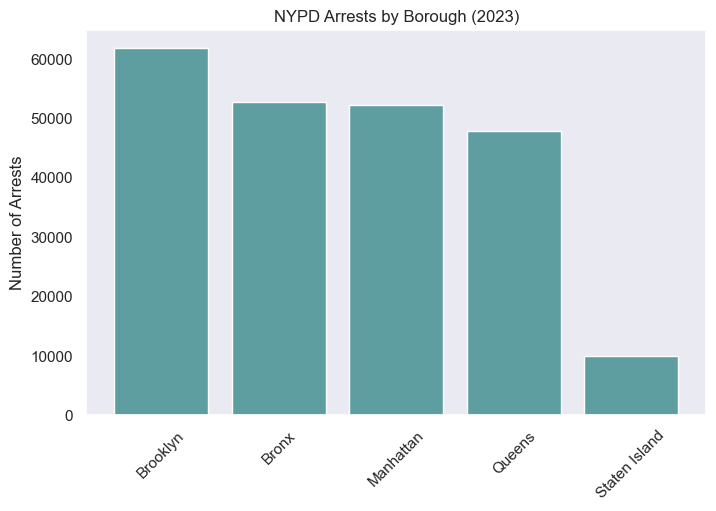

Top 10 Precincts by Arrest Volume (2023):
          Borough  ARREST_PRECINCT  Arrests_2023
42      Manhattan               14          7639
4           Bronx               44          7148
24       Brooklyn               75          7146
0           Bronx               40          7116
62         Queens              103          6141
6           Bronx               46          5478
11          Bronx               52          5274
3           Bronx               43          5172
23       Brooklyn               73          5153
75  Staten Island              120          4860


In [55]:
boro_map = {"B": "Bronx", "K": "Brooklyn", "M": "Manhattan", "Q": "Queens", "S": "Staten Island"}
arrests_2023["Borough"] = arrests_2023["ARREST_BORO"].map(boro_map)

borough_counts = (
    arrests_2023.groupby("Borough").size().sort_values(ascending=False).reset_index(name="Arrests_2023")
)

plt.figure(figsize=(8,5))
plt.bar(borough_counts["Borough"], borough_counts["Arrests_2023"], color="cadetblue")
plt.title("NYPD Arrests by Borough (2023)")
plt.ylabel("Number of Arrests")
plt.xticks(rotation=45)
plt.show()

precinct_counts = (
    arrests_2023.groupby(["Borough", "ARREST_PRECINCT"]).size()
    .reset_index(name="Arrests_2023")
    .sort_values(by="Arrests_2023", ascending=False)
)

top_precincts = precinct_counts.head(10)
print("Top 10 Precincts by Arrest Volume (2023):")
print(top_precincts)

In [ ]:
# load acs data 
# temp data analysis

acs_path = "../data/demographic/2023.xlsx"
acs = pd.read_excel(acs_path, sheet_name="Data")

acs.head()

,Unnamed: 0,"Bronx County, New York",Unnamed: 2,Unnamed: 3,Unnamed: 4,"Kings County, New York",Unnamed: 6,Unnamed: 7,Unnamed: 8,"New York County, New York",...,Unnamed: 15,Unnamed: 16,"Richmond County, New York",Unnamed: 18,Unnamed: 19,Unnamed: 20,"New York city, New York",Unnamed: 22,Unnamed: 23,Unnamed: 24
0,Label,Estimate,Margin of Error,Percent,Percent Margin of Error,Estimate,Margin of Error,Percent,Percent Margin of Error,Estimate,...,Percent,Percent Margin of Error,Estimate,Margin of Error,Percent,Percent Margin of Error,Estimate,Margin of Error,Percent,Percent Margin of Error
1,SEX AND AGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Total population,"1,356,476",*****,"1,356,476",(X),"2,561,225",*****,"2,561,225",(X),"1,597,451",...,"2,252,196",(X),"490,687",*****,"490,687",(X),"8,258,035",*****,"8,258,035",(X)
3,Male,"641,290",±851,47.3%,±0.1,"1,219,299",±698,47.6%,±0.1,"761,219",...,48.8%,±0.1,"240,115",±716,48.9%,±0.1,"3,960,933","±1,423",48.0%,±0.1
4,Female,"715,186",±851,52.7%,±0.1,"1,341,926",±698,52.4%,±0.1,"836,232",...,51.2%,±0.1,"250,572",±716,51.1%,±0.1,"4,297,102","±1,423",52.0%,±0.1


In [34]:
acs.rename(columns={"Unnamed: 0": "Label"}, inplace=True)
cols = [
    "Label",
    "Bronx County, New York",
    "Kings County, New York",
    "New York County, New York",
    "Queens County, New York",
    "Richmond County, New York",
    "New York city, New York",
]
acs = acs[cols]
start_idx = acs.index[acs["Label"] == "Total population"][1]
acs_race = acs.loc[start_idx:].reset_index(drop=True)
acs_race = acs_race.head(15)
acs_race.columns = [
    "Label", "Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island", "NYC Total"
]
for col in ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island", "NYC Total"]:
    acs_race[col] = acs_race[col].astype(str).str.replace(",", "", regex=False).replace("*****", None)
    acs_race[col] = pd.to_numeric(acs_race[col], errors="coerce")

acs_race.set_index("Label", inplace=True)
acs_pct = acs_race.div(acs_race.loc["Total population"]) * 100
acs_pct = acs_pct.drop("Total population")

acs_tidy = acs_pct.reset_index().melt(
    id_vars="Label", var_name="Borough", value_name="Percent"
)

acs_tidy = acs_tidy.dropna(subset=["Percent"])
acs_tidy["Percent"] = acs_tidy["Percent"].round(2)
acs_tidy.head(15)

,Label,Borough,Percent
0,One race,Bronx,85.85
1,Two or More Races,Bronx,14.15
2,One race,Bronx,85.85
3,White,Bronx,12.47
4,Black or African American,Bronx,33.67
5,American Indian and Alaska Native,Bronx,1.79
13,Asian,Bronx,4.29
14,One race,Brooklyn,89.01
15,Two or More Races,Brooklyn,10.99
16,One race,Brooklyn,89.01
